# AirBNB Seattle dataset

First read in the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [8]:
# Store the key performance indicator for how popular a house is in a variable, so that we can reference it at multiple places
kpi = 'occupancy_rate'

## Listings.csv

Take a look at the data set describing all the different appartments that are being offered at airBNB in seattle.

In [3]:
df_listing = pd.read_csv('./data/listings.csv')
df_listing.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview        ...         \
0                                                NaN        ...          
1  Queen Anne is a wonderful, truly functional vi...        ...          
2  Upper Queen Anne is a charming neighborhood fu...        ...          
3                                                NaN        ...          
4  We are in the beautiful neighborhood of Queen ...        ...          

  review_scores_value requires_license license jurisdiction_names  \
0                10.0                f     NaN         WASHINGTON   
1                10.0                f     NaN         WASHINGTON   
2                10.0                f     NaN         WASHINGTON   
3                 NaN                f     NaN         WASHINGTON   
4                 9.0                f     NaN         WASHINGTON   

  instant_bookable cancellation_policy  require_guest_profile_picture  \
0                f            moderate                              f   
1                f              strict                              t   
2                f              strict                              f   
3                f            flexible                              f   
4                f              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   
3                                f                              1   
4                                f                              1   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  
3               NaN  
4              0.89  

[5 rows x 92 columns]

## Reviews.csv

Take a look at the data set describing the different reviews.

In [4]:
df_reviews = pd.read_csv('./data/reviews.csv')
df_reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

## Calendar.csv

Take a look at the data set describing the different bookings for an apartment. 

In [5]:
df_calendar = pd.read_csv('./data/calendar.csv')
df_calendar.head()

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

## Data preparation



Create a dataframe that contains the information about how often an appartment is booked. Later on it turned out that the column that I calculated here already existed in the listings.csv file:)

In [6]:
# First do some group by and pivotting to get the information we need.
df_occupied = pd.DataFrame(pd.pivot_table(df_calendar.groupby(['listing_id', 'available']).count()['date'].reset_index(),index=["listing_id"], columns='available', values='date').reset_index(), columns=['listing_id', 'f', 't']).fillna(0)
# Then rename our columns, available(f) means that the house was occupied, available(t) means that the house was available
df_occupied.columns = ['listing_id', 'occupied', 'available']

# Create a column percentage that shows how often an appartment is occupied. This will be our main value that we want to demistify
df_occupied['percentage'] = df_occupied['occupied'] / (df_occupied['available'] + df_occupied['occupied'])

# First I made sure that all apartments contained 365 rows in the calendar.csv and then concluded that we don't need the available and occupied column.
# So we can remove the other unnecessary columns
df_occupied.drop(['available', 'occupied'], axis=1, inplace=True)

#### Merge the data of calendar.csv and listing.csv

Now we want to create a dataframe that contains data about the appartments and their occupation.

In [7]:
# Join two dataframes on listing_id
data = df_listing.merge(df_occupied, left_on='id', right_on='listing_id', how='inner')

In [8]:
# The ID's in this dataframe were only usefull for making joins between the datasets, but not for any sort of prediction.
# Therefore we drop the ID columns.
data.drop(['id', 'scrape_id', 'host_id','listing_id', 'latitude', 'longitude', 'license'], axis=1, inplace=True)

#### Investigate missing data

Make sure we remove columns that don't have any additional value, like columns that have a lot of data missing.

In [9]:
list(data.columns[data.isnull().mean()>=0.90])

['square_feet']

In [10]:
data.drop(['square_feet'], axis=1, inplace=True)

Make sure that we remove columns that only contain a single value.

In [11]:
# Get overview of how many unique values a column has.
s = data.nunique()
unique_data = pd.DataFrame({'column':s.index, 'unique_values':s.values})

In [12]:
# Drop all columns that have a single value
for idx, row in unique_data.iterrows():
    if row.unique_values == 1:
        data.drop([row.column], axis=1, inplace=True)

#### Clean pricing information

Prep the data column that contain pricing information, remove preceding $ and thousand seperator ','.

In [13]:
# The pricing column contains all prices in dollars, but these are stored as an object. First we need to remove the $
cols_to_check = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
for col in cols_to_check:
    data[col] = data[col].apply(lambda x : x[1:].replace(",", "") if str(x).startswith("$") else x)
# Then we need to cast these columns to float.
data[cols_to_check] = data[cols_to_check].astype(float)

Then we want to make sure there are no missing values in columns weekly_price and monthly_price. This can be done by using the day price to calculate the monthly price and the weekly price. It was decided to muliply the day_price with 7 to calculate the week_price, and multiply the week_price with [4.34524] to get the month_price.

In [14]:
# First make sure we have a weekly_price in all columns
data['weekly_price'] = data.apply(
    lambda row: row['price']*7 if np.isnan(row['weekly_price']) else row['weekly_price'],
    axis=1
)

# Next, we make sure that we a monthly_price in all cases
data['monthly_price'] = data.apply(
    lambda row: row['weekly_price']*4.34524 if np.isnan(row['monthly_price']) else row['monthly_price'],
    axis=1
)

#### Check how many values are missing and drop some rows accordingly

In [15]:
sf = data.isnull().mean()
missing_data = pd.DataFrame({'column':sf.index, 'percentage':sf.values})

In [17]:
missing_data.head()

column  percentage
0  listing_url    0.000000
1         name    0.000000
2      summary    0.046359
3        space    0.149031
4  description    0.000000

#### Correlation heatmap

An interesting thing to look at might be the correlation heatmap. After looking at the heatmap it turned out that the column that I calculated in the steps above are exactly the same as column availability_365, therefore we have to remove this column from further analysis. From the heatmap it also turns out that columns host_listings_count and  host_total_listings_count correlates perfect. Therefore one of these columns has to be removed from the analysis.

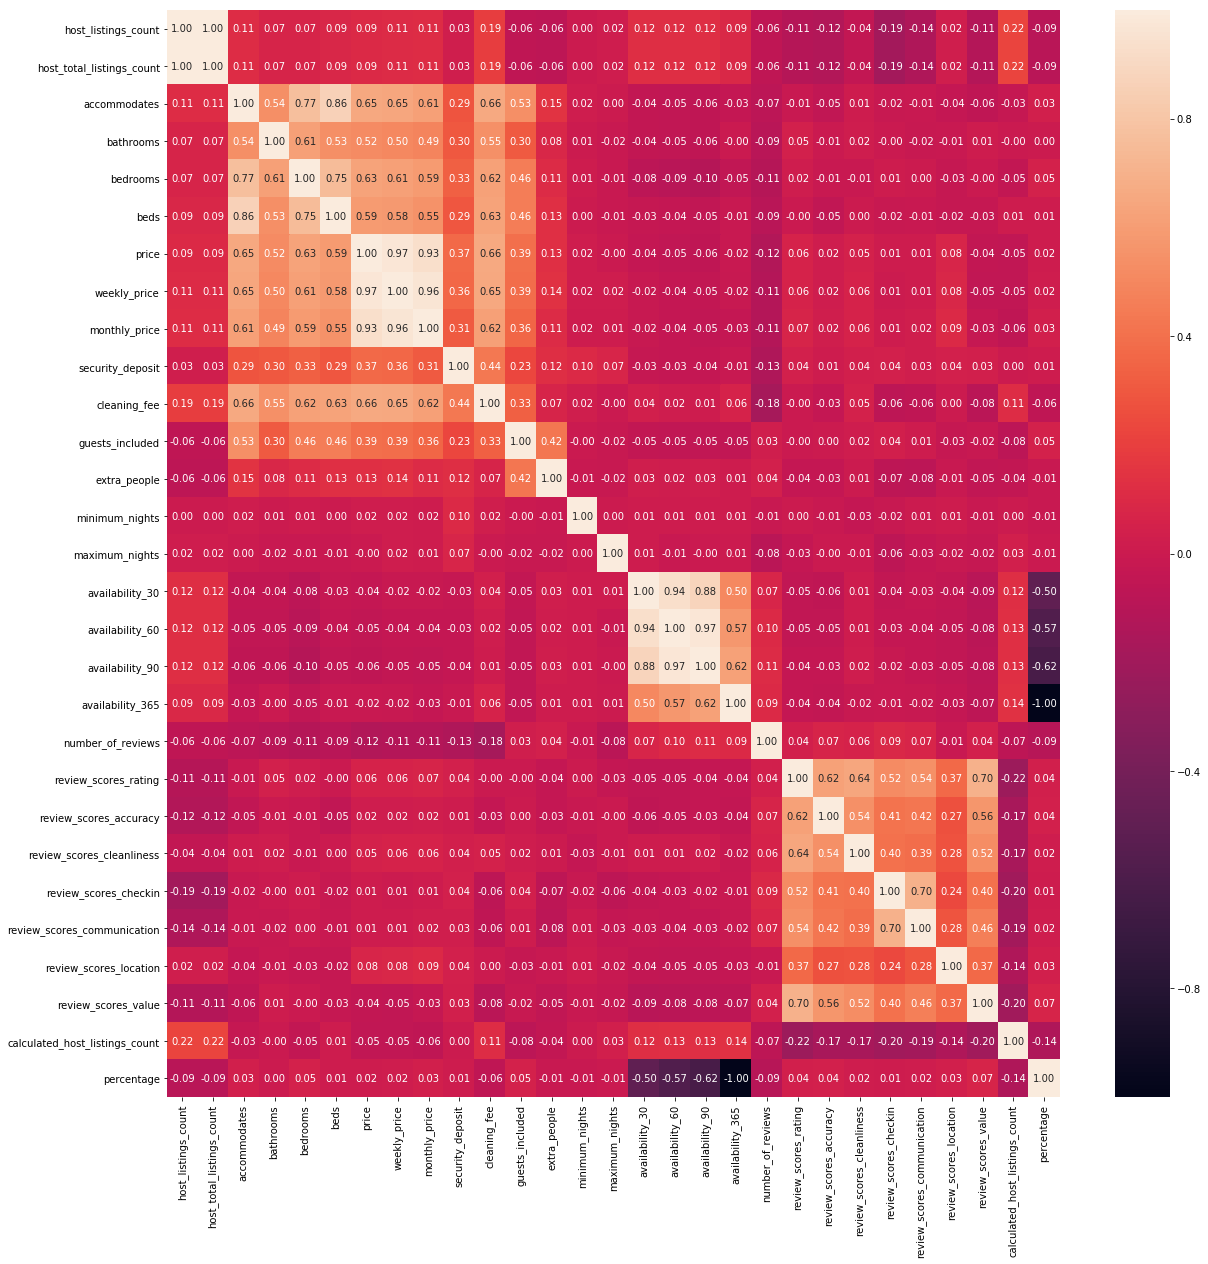

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data.corr(), ax=ax, annot=True, fmt=".2f");

Take a look at how we should interpret the variable availibility_365.

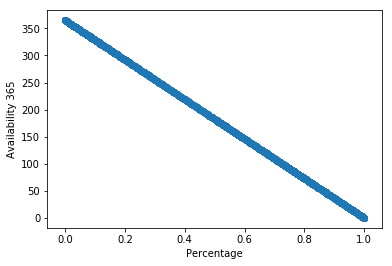

In [20]:
# Create a scatter plot
ut.scatter_plot(data, kpi, 'percentage', plt);

This means that the lower the value in availability_365, the higher the occupancy rate is for that given house. So a low value for availability_365 is good. For now we can drop this variable percentage. It also turned out from the heatmap that the column host_total_listings_count correlates perfect with host_listings_count, therefore we have to drop one of these variables as well. Then we can create the heatmap again.

In [21]:
# Drop columns as discussed.
data.drop(['percentage', 'host_total_listings_count'], axis=1, inplace=True)

<a id='visualize'></a>
## Visualizing data

#### Correlations of numeric columns

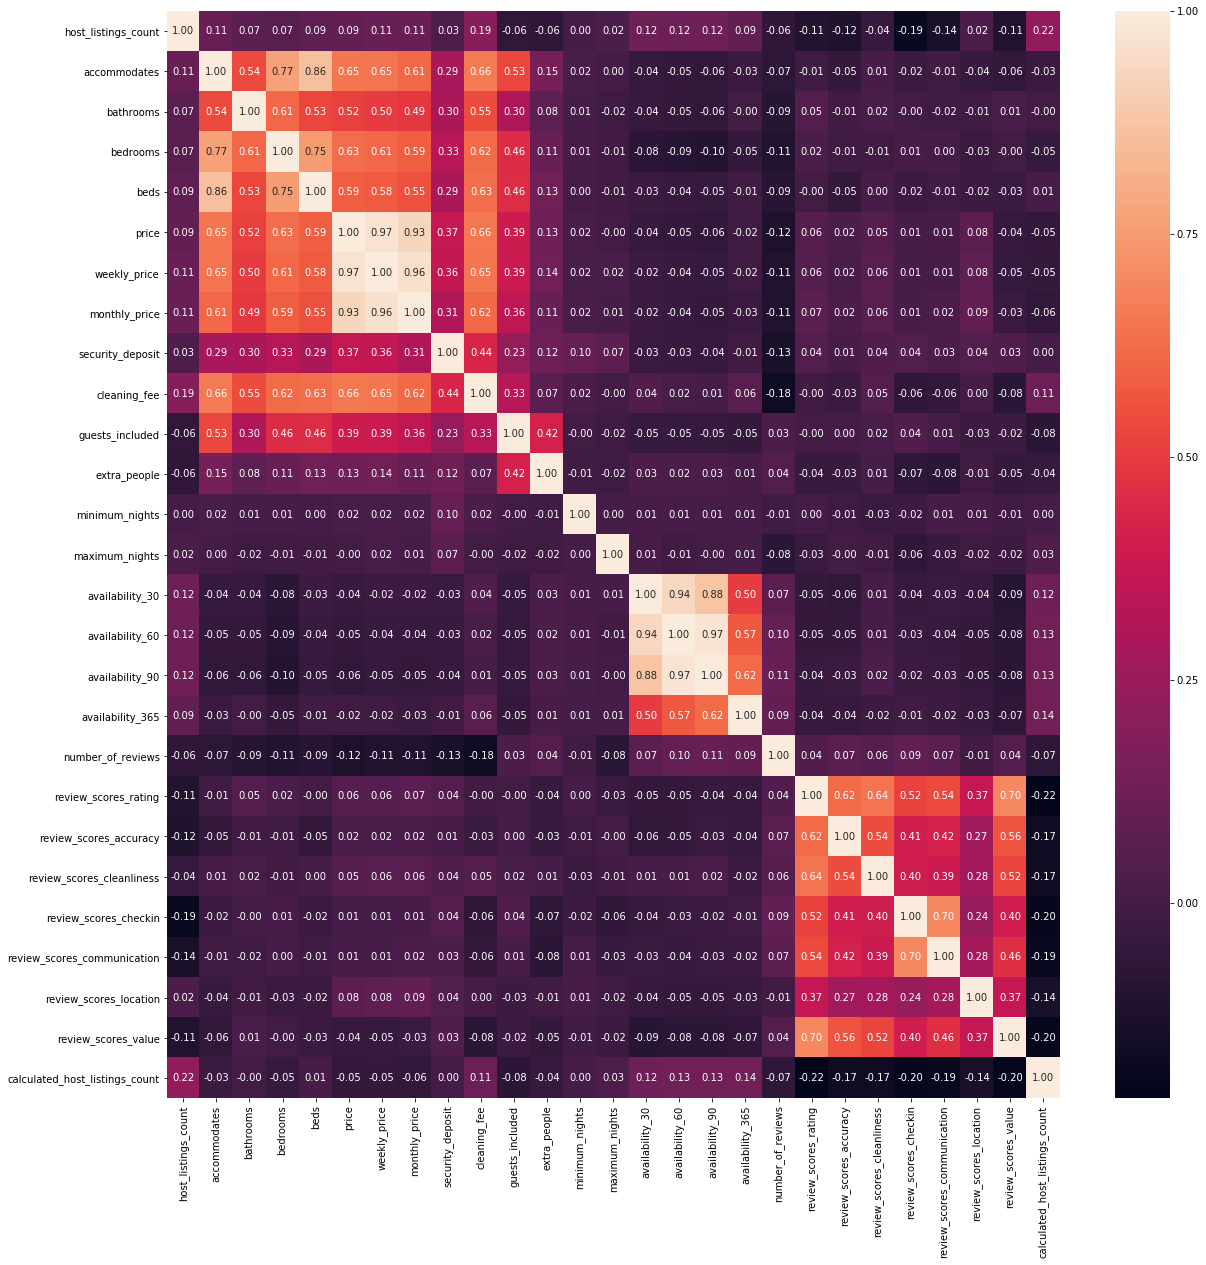

In [22]:
# Create the heatmap again.
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data.corr(), ax=ax, annot=True, fmt=".2f");

From the heatmap are no real interesting correlations for the availability_365 variable. Only interesting thing to note is the correlation between calculated_host_listings_count and availability_365. Looking at boxplot I'm not really sure how to interpret the results.

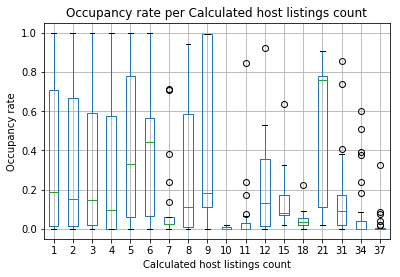

In [9]:
ut.box_plot(data, kpi, 'calculated_host_listings_count', plt);

#### Relationship between reviews and availability

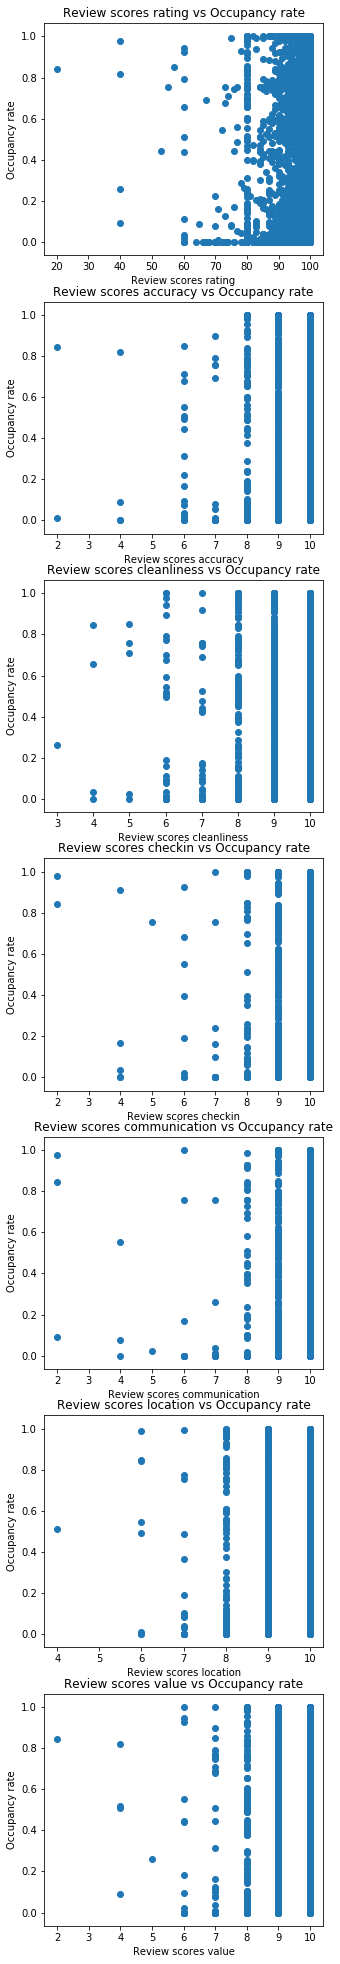

In [10]:
cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

fig, ax = plt.subplots(figsize=(5, 35))
for idx, col in enumerate(cols):
    plt.subplot(len(cols), 1, idx+1) #create subplots
    ut.scatter_plot(data, kpi, col, plt);

#### Relationship between the number of reviews and availaility.
It appears that having a lot of reviews can mean two things. Either a lot of people give reviews because they thought a house should not be rented by other people and they gave a bad review. Or they would really recommend the house and therefore gave a review.

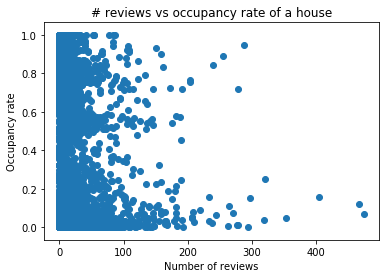

In [11]:
ut.scatter_plot(data, kpi, 'number_of_reviews', plt, '# reviews vs occupancy rate of a house');

#### Relationship between the price and availaility.
There appears to be no relationship.

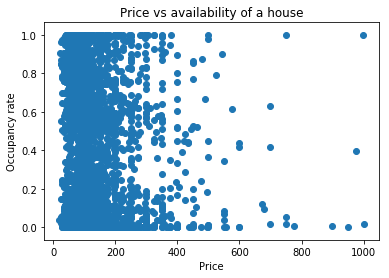

In [12]:
ut.scatter_plot(data, kpi, 'price', plt, 'Price vs availability of a house');

#### Relationship between the security deposit and availability.
There appears to be no relationship.

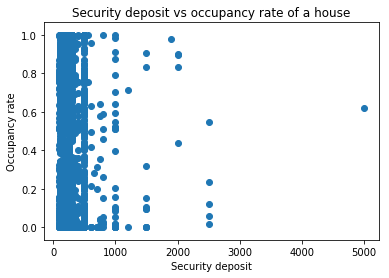

In [14]:
ut.scatter_plot(data, kpi, 'security_deposit', plt, 'Security deposit vs occupancy rate of a house');

#### Relationship between number of guests and availability
It appears that houses targetting groups for 6 or 10 people are the most wanted. In the box plot the green line is the median.

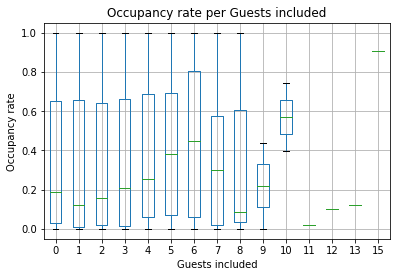

In [15]:
ut.box_plot(data, kpi, 'guests_included', plt);

Looking at the averages this is confirmed.

In [16]:
ut.aggr(data, kpi, 'guests_included')

guests_included  occupancy_rate
0                 0        0.333830
1                 1        0.320802
2                 2        0.325329
3                 3        0.352534
4                 4        0.372741
5                 5        0.419374
6                 6        0.442639
7                 7        0.363405
8                 8        0.324772
9                 9        0.219178
10               10        0.569863
11               11        0.019178
12               12        0.101370
13               13        0.123288
14               15        0.906849

#### Cancellation policy influence on availability
Based on the medians it appears that a moderate cancellation policy decreases the availability and thus increases occupancy rate.

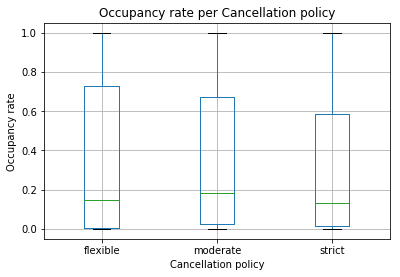

In [17]:
ut.box_plot(data, kpi, 'cancellation_policy', plt);

Looking at the averages it shows that a moderate cancellation policy is better for the occupancy rate compared to a strict cancellation policy. The same could be noted for a flexible cancellation policy.

In [18]:
ut.aggr(data, kpi, 'cancellation_policy')

cancellation_policy  occupancy_rate
0            flexible        0.344079
1            moderate        0.343397
2              strict        0.305103

#### Room type influence on availability
An entire house is by far the most wanted sort of room type.

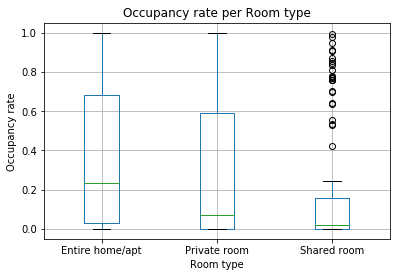

In [19]:
ut.box_plot(data, kpi, 'room_type', plt);

Looking at the average this is confirmed.

In [20]:
ut.aggr(data, kpi, 'room_type')

room_type  occupancy_rate
0  Entire home/apt        0.360391
1     Private room        0.275945
2      Shared room        0.185997

#### Require guest profile picture influence on availability

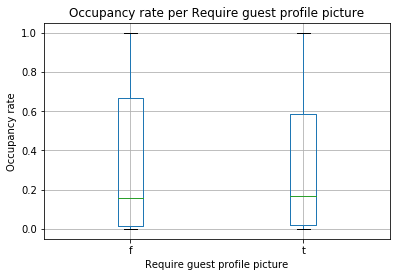

In [21]:
ut.box_plot(data, kpi, 'require_guest_profile_picture', plt);

Not needing a guest profile picture does on average increase occupancy rate. But looking at the median (boxplot) this does not appear to be true.

In [22]:
ut.aggr(data, kpi, 'require_guest_profile_picture')

require_guest_profile_picture  occupancy_rate
0                             f        0.331042
1                             t        0.311390

## Time trends

#### Percentage of houses booked in 2016
There appear to be three seasonal trends. One is around the start of the year. The second is somewhere around april, my best guess is that this might have something to do with spring break. The last trend is the start of the summer, somewhere around mid july.

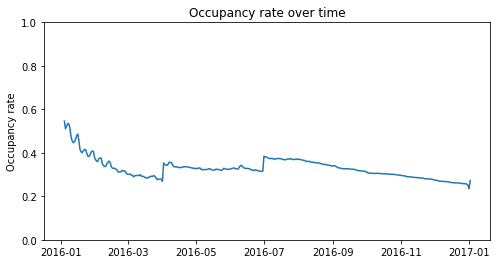

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
ut.date_plot(data_calendar, 'occupancy_rate', plt);
ax.set_ylim([0, 1]);

#### Number of reviews over the past few years
Just curious if there is some trend in the number of reviews. What you can see here is that there is some seasonal influence on the number of reviews, and that airbnb is growing as a platform and more and more people give a review.

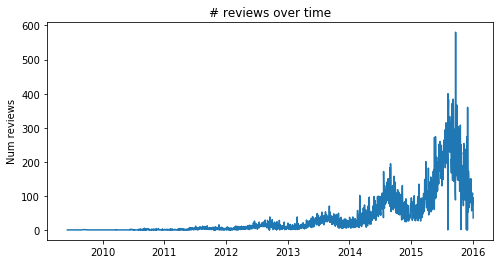

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
ut.date_plot(data_review, 'num_reviews', plt, '# reviews over time');